In [454]:
import os
import subprocess
import numpy as np
import sys
from scipy.spatial import distance
def roc_auc_ef(total, actives, candidate_name):

    import os
    from importlib.resources import path
    from sklearn import metrics
    import matplotlib.pyplot as plt
    import numpy as np


    num_of_actives = len(actives)
    num_of_decoys = len(total) - num_of_actives

    act, dcy = 0, 0
    fpr, tpr = [], []
    for candidate in total:
        if candidate in actives:
            act += 1
        else:
            dcy += 1
        fpr.append(dcy/num_of_decoys)
        tpr.append(act/num_of_actives)

    with plt.style.context(['science', "high-vis", "grid"]):
        pparam = dict(xlabel='False Positive Rate', ylabel='True Positive Rate')
        fig, ax = plt.subplots()
        ax.set_title(f"ROC of {candidate_name}")
        ax.plot(fpr, tpr, label="NCF-LBVS")
        ax.plot(fpr, fpr, label="Random")
        ax.legend(title=f"AUC = {metrics.auc(fpr, tpr):.5f}")
        ax.autoscale(tight=True)
        ax.set(**pparam)
        ax.set_ylim(bottom=-0.03, top=1.03)
        ax.set_xlim(left=-0.03, right=1.03)
#         fig.savefig(f"ROC_{candidate_name}.svg"

    data_set_count = len(total)
    active_ratio = np.divide(num_of_actives, data_set_count)
    Subsets = [[int(round(data_set_count * 0.01)), 1 ],
               [int(round(data_set_count * 0.05)), 5 ],
               [int(round(data_set_count * 0.10)), 10],
               [int(round(data_set_count * 0.15)), 15],
               [int(round(data_set_count * 0.20)), 20],
               [int(round(data_set_count * 0.25)), 25],
               [int(round(data_set_count * 0.50)), 50],
               [int(round(data_set_count * 0.99)),100]]

    EF_active_found  = 0.0
    active_found     = 0.0
    active_not_found = 0.0
    Active_Found     = []


    print(f"""\
Number of total ligands: {data_set_count}\n
Number of known actives: {num_of_actives}\n
Number of known decoys: {num_of_decoys}\n
AUC : {metrics.auc(fpr, tpr):.5f}\n
""")
    
    for data_set_index, compound in enumerate(total):
        Name = compound.split()

        if data_set_index <= num_of_actives and Name[0] in actives:
            active_found += 1.0
        elif data_set_index > num_of_actives and Name[0] in actives:
            active_not_found += 1.0

        ## For enrichment factor calculation
        if Name[0] in actives:
            EF_active_found += 1.0
            Active_Found.append(Name[0])

    # Calculate the Enrichment factor at certain subset ratio
        for Subset in Subsets:
            if data_set_index == Subset[0]:
                EF = float(EF_active_found / data_set_index) / active_ratio
                print(f"EF at {Subset[1]} % : {EF:.2f}\n")

In [467]:
os.chdir("/root/autodl-tmp/lbvs/test_dude5/esr2/")

In [468]:
from pathlib import Path
pre_filtered_pdbqt_lis = list(subprocess.check_output("find . -name '*best_position.pdbqt' -type f", shell=True).decode(sys.stdout.encoding).split("\n"))
pdbqt_lis = [i for i in pre_filtered_pdbqt_lis if i != ""]
# for i in pdbqt_lis:
#     print(Path(i).stem.replace("_best_position", ""))

In [469]:
import math
simi_vec, lig_name = [], []
for i in pdbqt_lis:
    with open (i) as tmpfile:
        lines = tmpfile.readlines()
        lig_name.append(Path(i).stem.replace("_best_position", ""))
        score = float(lines[3].split()[-3].replace('=', '')) 
        # vhd = -(float(lines[6].split()[-2].replace('=', ''))**1.5) # vdw + hbond + desolv
        # elec = float(lines[7].split()[-2].replace('=', '')) # eletrostatic
        # internal = float(lines[10].split()[-2].replace('=', ''))
        # torsion  = float(lines[11].split()[-2].replace('=', ''))
        # unbound = float(lines[12].split()[-2].replace('=', ''))
        simi_vec.append(score)

In [470]:
ref_ind = lig_name.index("original_aligned_lig")
ref_vec = simi_vec[ref_ind]

In [471]:
del simi_vec[ref_ind]
del lig_name[ref_ind]

In [472]:
ref_vec

-278.17

In [473]:
tanimoto_simi = [vec/1 for vec in simi_vec]

In [474]:
# import sklearn.metrics as sm
# # for vec in simi_vec:
# #     print(sm.r2_score(ref_vec, vec))
# tanimoto_simi = [sm.d2_pinball_score(ref_vec,vec) for vec in simi_vec]

Number of total ligands: 2054

Number of known actives: 36

Number of known decoys: 2018

AUC : 0.77299


EF at 1 % : 32.60

EF at 5 % : 10.52

EF at 10 % : 5.57

EF at 15 % : 3.70

EF at 20 % : 2.78

EF at 25 % : 2.22

EF at 50 % : 1.61

EF at 100 % : 1.01



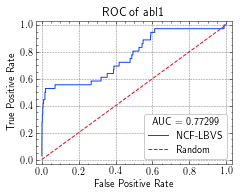

In [475]:
if len(np.argsort(np.array(tanimoto_simi))) == len(simi_vec):
    ranked = [lig_name[i] for i in np.argsort(np.array(tanimoto_simi))]
    actives = [i for i in lig_name if i.startswith("CHEMBL")]
    roc_auc_ef(ranked, actives, "abl1")